In [1]:
# import necessary pacakages
import pandas as pd
import numpy as np
from lib.neural_ode_surv import *
from lib.utils import *
import warnings
import matplotlib.pyplot as plt

# check for available GPUs
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Time to multiple events prediction example : Framingham data
### Loading and pre-processing the data
Event of interest : ANYCHD (Angina Pectoris, Myocardial infarction, Coronary Insufficiency, or Fatal Coronary Heart Disease)

Competing event : Death from any cause

In [2]:
# For more details on the dataset and covariates in Framingham data, 
# see : https://biolincc.nhlbi.nih.gov/media/teachingstudies/FHS_Teaching_Longitudinal_Data_Documentation_2021a.pdf?link_time=2022-02-03_18:20:47.023970
# this publicly available data has a person-time format for longitudinal measurements 
df_framingham = pd.read_csv('data/framingham.csv') 

# Specify categorical features
feat_cat = ['SEX', 'CIGPDAY', 'CURSMOKE','educ', 'DIABETES', 'PREVSTRK', 'PREVHYP', 'BPMEDS']
# Specify continuous features
feat_cont = ['AGE', 'SYSBP', 'DIABP', 'TOTCHOL', 'HDLC', 'LDLC', 'BMI', 'GLUCOSE', 'HEARTRTE']
# Specify features which SurvLatent ODE is set to reconstruct
feat_reconstr = ['SYSBP', 'DIABP', 'TOTCHOL', 'HDLC', 'LDLC', 'BMI', 'GLUCOSE', 'HEARTRTE']
# Specify data_info_dic as follows 
# id_col : unique identifier for a patient
# event_col : columns correspond to event indicator; this should be binary
# time_col : column corresponds to time of measurement
# time_to_event_col : column corresponds to observed time to event (i.e. t_i = min(T_i, C_i))
# feat_cat : list containing a set of categorical features
# feat_cont : list containing a set of continuous valued features
data_info_dic = {'id_col':'RANDID', 'event_col':['ANYCHD', 'DEATH'], 'time_to_event_col':['TIMECHD', 'TIMEDTH'],
                 'time_col':'TIME', 'feat_cat':feat_cat, 'feat_cont':feat_cont}

feats_dim = len(feat_cat) + len(feat_cont)
reconstr_dim = len(feat_reconstr)
if type(data_info_dic['event_col']) == list:
    n_events = len(data_info_dic['event_col'])
else:
    n_events = 1
# Given that the Framingham study is a long follow-up study which spans about 20 years (or around 7500 days),  
# we discretize follow-up time by 10 days. Therefore, our time unit is 10-day.
df_framingham[data_info_dic['time_col']] = np.round(df_framingham[data_info_dic['time_col']].values/10)
df_framingham[data_info_dic['time_to_event_col']] = np.round(df_framingham[data_info_dic['time_to_event_col']].values/10)

# We perform 0.65-0.15-0.2 (train-valid-test) split
test_set_frac = 0.2; train_set_frac = 0.65
random_seed = 1991 # set random seed for reproducibility
np.random.seed(random_seed)

sample_ids = set(df_framingham.RANDID.values)
sample_ids_test = set(np.random.choice(list(sample_ids), size = int(len(sample_ids)*test_set_frac), replace = False))
sample_ids_train = 	set(np.random.choice(list(sample_ids - sample_ids_test),
                                         size = int(len(sample_ids - sample_ids_test)*train_set_frac/(1-test_set_frac)),
                                         replace = False))
sample_ids_valid = sample_ids - sample_ids_test - sample_ids_train

data_test = (df_framingham.loc[df_framingham.RANDID.isin(sample_ids_test)].
             sort_values([data_info_dic['id_col'], data_info_dic['time_col']], ascending=(True, True)))
data_train = (df_framingham.loc[df_framingham.RANDID.isin(sample_ids_train)].
              sort_values([data_info_dic['id_col'], data_info_dic['time_col']], ascending=(True, True)))
data_valid = (df_framingham.loc[df_framingham.RANDID.isin(sample_ids_valid)].
              sort_values([data_info_dic['id_col'], data_info_dic['time_col']], ascending=(True, True)))

# outlier processing
# We threshold outliers (i.e. feature vals < 0.005 percentile of corresponding feature vals in training set 
# AND feature vals > 0.995 percentile of corresponding features vals in training set)
feats_oi = feat_cont + ['CIGPDAY']
feat_to_min_max_dict = {}
for feat in feats_oi:
    min_feat = np.quantile(data_train[feat].dropna().values, q=0.005)
    max_feat = np.quantile(data_train[feat].dropna().values, q=0.995)
    data_train.loc[data_train[feat] < min_feat, feat] = min_feat
    data_train.loc[data_train[feat] > max_feat, feat] = max_feat
    feat_to_min_max_dict[feat] = (min_feat, max_feat)
    # control outliers in the valid + test cohorts using training set
    data_valid.loc[data_valid[feat] < min_feat, feat] = min_feat
    data_valid.loc[data_valid[feat] > max_feat, feat] = max_feat
    data_test.loc[data_test[feat] < min_feat, feat] = min_feat
    data_test.loc[data_test[feat] > max_feat, feat] = max_feat

## Choose model hyperparameters and instantiate the model object

In [3]:
# lr : learning rate
# surv_loss_scale : determines the scaling factor for the survival loss in the total loss
# wait_until_full_surv_loss : wait # epochs until the full survival loss scaling, which allows the model to learn input representation before tuning survival estimates.
batch_size = 100; lr = 0.01; surv_loss_scale = 100; wait_until_full_surv_loss = 3; early_stopping = True;
# ODE-RNN encoder
# enc_f_nn_layers : # of layers in the neural networks function f() for learning the latent dynamics on the encoder side
# enc_latent_dim : dimensionality in the latent embedding on the encoder side
# num_units_gru : # of units in each GRU cell
enc_latent_dim = 50; enc_f_nn_layers = 5; num_units_gru = 80; 

# Decoder 
# dec_g_nn_layers : # of layers in the neural networks function g() for learning the latent dynamics on the decoder side
# dec_latent_dim : dimensionality in the latent embedding on the decoder side
# haz_dec_layers : # of layers in the cause-specific decoder module for hazard estimation
# num_units_ode : # of units in function f() and g()
dec_g_nn_layers = 7; dec_latent_dim = 40; haz_dec_layers = 3; num_units_ode = 70

# Specify the prediction window to 8000 days from the entry with 10-day as a unit time
max_pred_window = 800
n_epochs =30 # number of training epochs

# instantiate the model :
model = SurvLatentODE(input_dim=feats_dim, reconstr_dim=reconstr_dim, dec_latent_dim=dec_latent_dim,
                      enc_latent_dim=enc_latent_dim, enc_f_nn_layers=enc_f_nn_layers, 
                      dec_g_nn_layers=dec_g_nn_layers, num_units_ode=num_units_ode, num_units_gru=num_units_gru,
                      device=DEVICE, n_events=n_events, haz_dec_layers=haz_dec_layers)
# set the unique identifier for the corresponding training
run_id = 'framingham_competing_events_example_v1_1'

## Training and evaluating the model

In [ ]:
# train model
# note that samples with event times of zero (i.e. t_i = 0; event time overlapping the latest observation times) are excluded.
model.fit(data_train, data_valid, data_info_dic,
          max_pred_window=max_pred_window, run_id=run_id, n_epochs=n_epochs,
          batch_size=batch_size, surv_loss_scale=surv_loss_scale, early_stopping=early_stopping,
          feat_reconstr=feat_reconstr, wait_until_full_surv_loss=wait_until_full_surv_loss, random_seed=random_seed)

Pre-processing data...: 100%|██████████| 2882/2882 [00:00<00:00, 25792.93it/s]


excluded samples due to event times overlapping last observation times (i.e. remaining t_i = 0) :  [76273, 208566, 231492, 428306, 445400, 556045, 571377, 599475, 797308, 946128, 972314, 1075504, 1080397, 1232204, 1263082, 1406606, 1568334, 1663651, 1695438, 1798396, 1954038, 2087324, 2108588, 2134396, 2180046, 2181152, 2408348, 2434794, 2448708, 2474378, 2483517, 2507740, 2564697, 2640601, 2646666, 2682411, 2708769, 2727755, 2839250, 2865166, 2951629, 3117784, 3235453, 3361368, 3455001, 3587516, 3603542, 3683894, 3702628, 3710385, 3779954, 3810088, 3915943, 3927641, 4030316, 4066905, 4210168, 4220542, 4227351, 4229307, 4244133, 4295921, 4362066, 4504564, 4543147, 4637896, 4645346, 4700914, 4719511, 4754059, 4757585, 4897828, 4903592, 5130897, 5187398, 5266590, 5386797, 5406199, 5561922, 5571109, 5610759, 5611619, 5654796, 5784616, 5837883, 5871074, 5917953, 6171121, 6442383, 6662624, 6720746, 6759187, 7165088, 7173129, 7215259, 7392212, 7414089, 7416933, 7447033, 7507638, 7568367, 767

Pre-processing data...: 100%|██████████| 666/666 [00:00<00:00, 28933.72it/s]


excluded samples due to event times overlapping last observation times (i.e. remaining t_i = 0) :  [414678, 512339, 1101060, 2080190, 2097493, 3158323, 3718050, 4233073, 4588247, 4614345, 4726021, 5080716, 5865112, 6316687, 6949688, 7410564, 7546881, 7559394, 7668298, 8083473, 8466833, 9380233, 9802787, 9868819]
n =  24


/Users/intaemoon/github/survlatent_ode/lib/utils.py



using currently existing directory :  model_performance/framingham_competing_events_example_v1_1
using currently existing directory :  surv_curves/framingham_competing_events_example_v1_1


Training across 30 epochs:   3%|▎         | 27/840 [01:27<44:03,  3.25s/it]

Epoch :  1



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]




============ Validation set performance ============
survival log-likelihood :  -2480.2134
reconstr. likelihood :  0.8462
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0544, 0.375: 0.0812, 0.5: 0.1043, 0.625: 0.1292, 0.75: 0.1492}
AUC(t) at the percentiles :  {0.25: 0.4976, 0.375: 0.5412, 0.5: 0.4937, 0.625: 0.4882, 0.75: 0.4897}
mean AUC(t) over 25-75 percentile :  0.502
Integrated BS(t) over 25-75 percentile :  0.0987
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.041, 0.375: 0.0599, 0.5: 0.0797, 0.625: 0.0991, 0.75: 0.1146}
AUC(t) at the percentiles :  {0.25: 0.4682, 0.375: 0.3996, 0.5: 0.4268, 0.625: 0.4508, 0.75: 0.4792}
mean AUC(t) over 25-75 percentile :  0.4477
Integrated BS(t) over 25-75 percentile :  0.0825
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model

Training across 30 epochs:   3%|▎         | 28/840 [01:34<1:00:08,  4.44s/it]

Training across 30 epochs:   7%|▋         | 55/840 [03:00<42:08,  3.22s/it]  

Epoch :  2



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]




============ Validation set performance ============
survival log-likelihood :  -2361.4944
reconstr. likelihood :  0.8455
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0532, 0.375: 0.0784, 0.5: 0.0995, 0.625: 0.1216, 0.75: 0.1387}
AUC(t) at the percentiles :  {0.25: 0.5945, 0.375: 0.6209, 0.5: 0.6134, 0.625: 0.6127, 0.75: 0.6014}
mean AUC(t) over 25-75 percentile :  0.6058
Integrated BS(t) over 25-75 percentile :  0.094
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0405, 0.375: 0.0587, 0.5: 0.0763, 0.625: 0.0927, 0.75: 0.1062}
AUC(t) at the percentiles :  {0.25: 0.6242, 0.375: 0.5871, 0.5: 0.582, 0.625: 0.5786, 0.75: 0.6027}
mean AUC(t) over 25-75 percentile :  0.5981
Integrated BS(t) over 25-75 percentile :  0.0782
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model

Training across 30 epochs:   7%|▋         | 56/840 [03:07<56:14,  4.30s/it]

Training across 30 epochs:  10%|▉         | 83/840 [04:35<40:17,  3.19s/it]

Epoch :  3



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]




============ Validation set performance ============
survival log-likelihood :  -2342.0403
reconstr. likelihood :  0.8455
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0523, 0.375: 0.076, 0.5: 0.0953, 0.625: 0.1141, 0.75: 0.1282}
AUC(t) at the percentiles :  {0.25: 0.6027, 0.375: 0.6424, 0.5: 0.6654, 0.625: 0.6957, 0.75: 0.7136}
mean AUC(t) over 25-75 percentile :  0.6464
Integrated BS(t) over 25-75 percentile :  0.0897
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0408, 0.375: 0.0586, 0.5: 0.0751, 0.625: 0.0899, 0.75: 0.1021}
AUC(t) at the percentiles :  {0.25: 0.5782, 0.375: 0.5848, 0.5: 0.6055, 0.625: 0.628, 0.75: 0.6479}
mean AUC(t) over 25-75 percentile :  0.5997
Integrated BS(t) over 25-75 percentile :  0.0764
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model

Training across 30 epochs:  10%|█         | 84/840 [04:42<52:41,  4.18s/it]

Training across 30 epochs:  13%|█▎        | 111/840 [06:08<39:20,  3.24s/it]

Epoch :  4



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]




============ Validation set performance ============
survival log-likelihood :  -2338.9626
reconstr. likelihood :  0.8455
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0522, 0.375: 0.0756, 0.5: 0.0938, 0.625: 0.1093, 0.75: 0.1198}
AUC(t) at the percentiles :  {0.25: 0.6082, 0.375: 0.6487, 0.5: 0.6517, 0.625: 0.6809, 0.75: 0.7048}
mean AUC(t) over 25-75 percentile :  0.6451
Integrated BS(t) over 25-75 percentile :  0.0875
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0416, 0.375: 0.0589, 0.5: 0.0738, 0.625: 0.0865, 0.75: 0.0968}
AUC(t) at the percentiles :  {0.25: 0.5571, 0.375: 0.5866, 0.5: 0.5979, 0.625: 0.6387, 0.75: 0.6575}
mean AUC(t) over 25-75 percentile :  0.5943
Integrated BS(t) over 25-75 percentile :  0.0744
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
mod

Training across 30 epochs:  13%|█▎        | 112/840 [06:15<51:33,  4.25s/it]

Training across 30 epochs:  17%|█▋        | 139/840 [07:41<37:23,  3.20s/it]

Epoch :  5



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]




============ Validation set performance ============
survival log-likelihood :  -2326.2202
reconstr. likelihood :  0.8455
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0519, 0.375: 0.0752, 0.5: 0.093, 0.625: 0.1093, 0.75: 0.1219}
AUC(t) at the percentiles :  {0.25: 0.6381, 0.375: 0.6635, 0.5: 0.6743, 0.625: 0.7001, 0.75: 0.7118}
mean AUC(t) over 25-75 percentile :  0.6672
Integrated BS(t) over 25-75 percentile :  0.0872
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0411, 0.375: 0.0577, 0.5: 0.0731, 0.625: 0.0864, 0.75: 0.097}
AUC(t) at the percentiles :  {0.25: 0.5498, 0.375: 0.5732, 0.5: 0.5857, 0.625: 0.6334, 0.75: 0.6558}
mean AUC(t) over 25-75 percentile :  0.5856
Integrated BS(t) over 25-75 percentile :  0.0739
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model

Training across 30 epochs:  17%|█▋        | 140/840 [07:47<49:26,  4.24s/it]

Training across 30 epochs:  20%|█▉        | 167/840 [09:15<37:05,  3.31s/it]

Epoch :  6



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]




============ Validation set performance ============
survival log-likelihood :  -2324.5017
reconstr. likelihood :  0.8453
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.052, 0.375: 0.0753, 0.5: 0.0935, 0.625: 0.1098, 0.75: 0.1212}
AUC(t) at the percentiles :  {0.25: 0.6158, 0.375: 0.6516, 0.5: 0.6559, 0.625: 0.6821, 0.75: 0.704}
mean AUC(t) over 25-75 percentile :  0.6493
Integrated BS(t) over 25-75 percentile :  0.0875
----------------------------------------------------
outcome :  2


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0407, 0.375: 0.0576, 0.5: 0.0729, 0.625: 0.0858, 0.75: 0.0958}
AUC(t) at the percentiles :  {0.25: 0.5921, 0.375: 0.6078, 0.5: 0.615, 0.625: 0.6554, 0.75: 0.6746}
mean AUC(t) over 25-75 percentile :  0.6188
Integrated BS(t) over 25-75 percentile :  0.0735
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...




Training across 30 epochs:  20%|██        | 168/840 [09:22<49:23,  4.41s/it]

Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model_performance/framingham_competing_events_example_v1_1/latest_model.pt




Training across 30 epochs:  23%|██▎       | 195/840 [10:58<35:54,  3.34s/it]

Epoch :  7



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]




============ Validation set performance ============
survival log-likelihood :  -2324.5627
reconstr. likelihood :  0.8453
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0521, 0.375: 0.0752, 0.5: 0.0934, 0.625: 0.1097, 0.75: 0.1208}
AUC(t) at the percentiles :  {0.25: 0.6217, 0.375: 0.6522, 0.5: 0.6628, 0.625: 0.6845, 0.75: 0.7051}
mean AUC(t) over 25-75 percentile :  0.6531
Integrated BS(t) over 25-75 percentile :  0.0874
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0408, 0.375: 0.0577, 0.5: 0.0729, 0.625: 0.0857, 0.75: 0.0956}
AUC(t) at the percentiles :  {0.25: 0.5961, 0.375: 0.6096, 0.5: 0.6183, 0.625: 0.66, 0.75: 0.6798}
mean AUC(t) over 25-75 percentile :  0.6218
Integrated BS(t) over 25-75 percentile :  0.0735
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model

Training across 30 epochs:  27%|██▋       | 223/840 [12:34<33:13,  3.23s/it]

Epoch :  8



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]




============ Validation set performance ============
survival log-likelihood :  -2321.2737
reconstr. likelihood :  0.8453
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.052, 0.375: 0.075, 0.5: 0.0931, 0.625: 0.1095, 0.75: 0.1206}
AUC(t) at the percentiles :  {0.25: 0.6255, 0.375: 0.661, 0.5: 0.6728, 0.625: 0.6979, 0.75: 0.7161}
mean AUC(t) over 25-75 percentile :  0.6611
Integrated BS(t) over 25-75 percentile :  0.0871
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0408, 0.375: 0.0576, 0.5: 0.0728, 0.625: 0.0857, 0.75: 0.0958}
AUC(t) at the percentiles :  {0.25: 0.6037, 0.375: 0.6147, 0.5: 0.6274, 0.625: 0.6677, 0.75: 0.681}
mean AUC(t) over 25-75 percentile :  0.6287
Integrated BS(t) over 25-75 percentile :  0.0735
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model_p

Training across 30 epochs:  27%|██▋       | 224/840 [12:41<44:31,  4.34s/it]



Storing the best model...


Training across 30 epochs:  30%|██▉       | 251/840 [14:08<33:03,  3.37s/it]

Epoch :  9



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]




============ Validation set performance ============
survival log-likelihood :  -2323.9417
reconstr. likelihood :  0.8453
----------------------------------------------------
outcome :  1
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 60 108 146 185 219]


/Users/intaemoon/github/survlatent_ode/lib/utils.py:1925: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cs_cif_total.append(np.asarray(cs_cif_local))
/Users/intaemoon/github/survlatent_ode/lib/utils.py:1926: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(ef_surv_prob), cs_cif_total


Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0521, 0.375: 0.0752, 0.5: 0.0932, 0.625: 0.1094, 0.75: 0.1204}
AUC(t) at the percentiles :  {0.25: 0.6384, 0.375: 0.6703, 0.5: 0.674, 0.625: 0.6915, 0.75: 0.7132}
mean AUC(t) over 25-75 percentile :  0.6667
Integrated BS(t) over 25-75 percentile :  0.0872
----------------------------------------------------
outcome :  2
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 95 152 201 247 323]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.041, 0.375: 0.0578, 0.5: 0.0728, 0.625: 0.0852, 0.75: 0.0951}
AUC(t) at the percentiles :  {0.25: 0.6119, 0.375: 0.633, 0.5: 0.6436, 0.625: 0.6834, 0.75: 0.7007}
mean AUC(t) over 25-75 percentile :  0.6419
Integrated BS(t) over 25-75 percentile :  0.0733
Event :  1 , Plotting 10 random survival curves...
Event :  2 , Plotting 10 random survival curves...


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model_

Training across 30 epochs:  30%|███       | 252/840 [14:14<42:01,  4.29s/it]

Training across 30 epochs:  32%|███▏      | 267/840 [15:11<43:35,  4.56s/it]

In [ ]:
# load the trained model
print('Loading the trained model...')
print('run_id : ', run_id)
path = 'model_performance/' + run_id + '/best_model.pt'
try:
    model_info = get_ckpt_model(path, model, DEVICE)
except:
    raise KeyError('Model not found...')

# Process the held-out test set 
batch_dict_test = model.process_eval_data(data_test, data_info_dic, max_pred_window=max_pred_window,
                                          run_id=run_id, feat_reconstr=feat_reconstr, model_info=model_info)
# Get estimated survival probabilities
# Note : survival probs are estimated from the latest observation for each sample
# due to generative nature, surv probs may be different across runs. In this example, we set the random seed to control non-deterministic elements
ef_surv_prob, cs_cif_total = model.get_surv_prob(batch_dict_test, model_info=model_info,
                                                 max_pred_window=max_pred_window, filename_suffix=run_id,
                                                 device=DEVICE, n_events=n_events)
# Evaluate the model on the held-out set and obtain model performance summary
df_test_result_comp = eval_model(model_info, batch_dict_test, ef_surv_prob, run_id=run_id,
                                 cs_cif_total=cs_cif_total, max_pred_window=max_pred_window, n_events=n_events)

In [6]:
df_test_result_comp

,param_set,best_epoch,ibs_event_1,ibs_event_2,mean_auc_event_1,mean_auc_event_2,bs 25 percentile_event_1,bs 25 percentile_event_2,bs 25 percentile se_event_1,bs 25 percentile se_event_2,...,auc 25 percentile se_event_1,auc 25 percentile se_event_2,auc 50 percentile_event_1,auc 50 percentile_event_2,auc 50 percentile se_event_1,auc 50 percentile se_event_2,auc 75 percentile_event_1,auc 75 percentile_event_2,auc 75 percentile se_event_1,auc 75 percentile se_event_2
result,,,,,,,,,,,,,,,,,,,,,
0,NaN,8,0.0936,0.07,0.6456,0.7168,0.052,0.0406,0.0062,0.0055,...,0.0473,0.042,0.6373,0.7122,0.0329,0.0344,0.7092,0.7247,0.0264,0.0297


## Plot estimated survival curves

In [8]:
np.shape(cs_cif_total)

(2, 847)

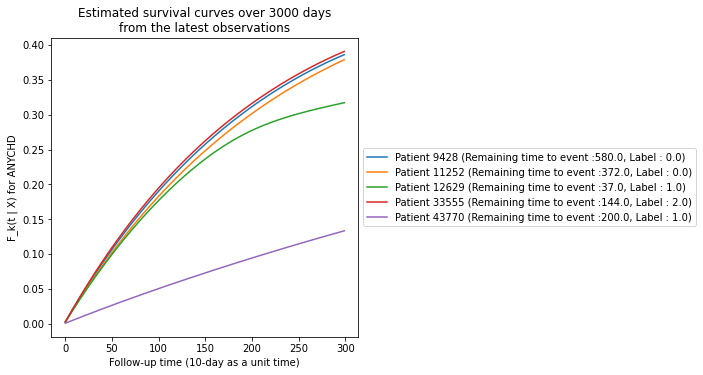

In [12]:
# Note that our prediction window is from time 0 to time 800 (i.e. 0 - 8000 days). The maximum prediction window can be made longer or shorter using 'max_pred_window'.
# Since survival probabilities are estimated from the latest observation of each patient (i.e. the latest observation is time 0 for each patient), 
# each patient has different last observation time in this case, resulting in a varying time window of estimated survival probabilities 
# For each patient, we include observed remaining time to event as well as event indicator.

sample_ids = batch_dict_test['sample_ids']
labels = batch_dict_test['labels']
remaining_time_to_event = batch_dict_test['remaining_time_to_event']

surv_prob = cs_cif_total[0]
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5.5))
for idx, surv_prob_ind in enumerate(surv_prob[5:10]):
    label = ('Patient ' + str(sample_ids[idx]) + ' (Remaining time to event :' +
             str(remaining_time_to_event[idx]) + ', Label : ' + str(labels[idx].numpy()[0]) + ')')
    axs.plot(np.arange(300), surv_prob_ind[0:300], label = label)
axs.set_title('Estimated survival curves over 3000 days\nfrom the latest observations')
axs.set_ylabel('F_k(t | X) for ANYCHD')
axs.set_xlabel('Follow-up time (10-day as a unit time)')
axs.legend(bbox_to_anchor=(1,0.5), loc="center left")